In [ ]:
!pip install git+https://github.com/TimeSynth/TimeSynth.git

In [359]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import timesynth as ts

import torch
from torch import sigmoid
from torch.optim import Adam
from torch.nn.functional import mse_loss
from torch.nn import Module, Linear

In [457]:
class MTRNNCell(Module):
    def __init__(self,
            input_output_size=1,
            fast_hidden_size=100,
            slow_hidden_size=30,
            tau_input_output=2,
            tau_fast_hidden=5,
            tau_slow_hidden=70):
        super().__init__()
        
        # hidden layer sizes
        self.input_output_size = input_output_size
        self.fast_hidden_size = fast_hidden_size
        self.slow_hidden_size = slow_hidden_size
        
        # decay rates
        self.tau_input_output = tau_input_output
        self.tau_fast_hidden = tau_fast_hidden
        self.tau_slow_hidden = tau_slow_hidden
        
        # linear mappings
        self.input_to_fast_mapping = Linear(self.input_output_size, self.fast_hidden_size)
        self.fast_to_fast_mapping = Linear(self.fast_hidden_size, self.fast_hidden_size)
        self.fast_to_slow_mapping = Linear(self.fast_hidden_size, self.slow_hidden_size)
        self.slow_to_slow_mapping = Linear(self.slow_hidden_size, self.slow_hidden_size)
        self.slow_to_fast_mapping = Linear(self.slow_hidden_size, self.fast_hidden_size)
        self.fast_to_output_mapping = Linear(self.fast_hidden_size, self.input_output_size)
        
    def forward(self, input, hidden_states):
        input_output_hidden_state, fast_hidden_state, slow_hidden_state = hidden_states
        
        new_fast_hidden_state = self._update_state(
            previous=fast_hidden_state, 
            new=[self.fast_to_fast_mapping(fast_hidden_state),
                self.slow_to_fast_mapping(slow_hidden_state),
                self.input_to_fast_mapping(input)],
            tau=self.tau_fast_hidden)
        
        new_slow_hidden_state = self._update_state(
            previous=slow_hidden_state, 
            new=[self.slow_to_slow_mapping(slow_hidden_state),
                self.fast_to_slow_mapping(fast_hidden_state)],
            tau=self.tau_slow_hidden)
        
        new_input_output_hidden_state = self._update_state(
            previous=input_output_hidden_state, 
            new=[self.fast_to_output_mapping(fast_hidden_state)],
            tau=self.tau_slow_hidden)
        
        output = sigmoid(new_input_output_hidden_state)
        hidden_states = (new_input_output_hidden_state,
                         sigmoid(new_fast_hidden_state),
                         sigmoid(slow_hidden_state))
        
        return output, hidden_states
        
    def _update_state(self, previous, new, tau):
        new_summed = torch.stack(new).sum(dim=0)
        return (1 - 1/tau) * previous + new_summed/tau

In [458]:
class MTRNN(Module):
    
    def __init__(self, cell_type=MTRNNCell, **kwargs):
        super().__init__()
        self.rnn = cell_type(**kwargs)
        
    def forward(self, input, hidden_state=None):
        if hidden_state is None:
            hidden_state = self._get_initial_hidden_states(input.size(1))
        output = torch.empty_like(input)
        for t in range(input.size(0)):
            output[t], hidden_state = self.rnn(input[t], hidden_state)
        return output, hidden_state
            
    def _get_initial_hidden_states(self, batch_size):
        # Allocate memory
        input_output_hidden_state = torch.FloatTensor(batch_size, self.rnn.input_output_size)
        fast_hidden_state = torch.FloatTensor(batch_size, self.rnn.fast_hidden_size)
        slow_hidden_state = torch.FloatTensor(batch_size, self.rnn.slow_hidden_size)
        
        # Initialize by sampling uniformly from (-sqrt(1/hidden_size), sqrt(1/hidden_size))
        input_output_hidden_state.uniform_(-np.sqrt(1/self.rnn.input_output_size), np.sqrt(1/self.rnn.input_output_size))
        fast_hidden_state.uniform_(-np.sqrt(1/self.rnn.fast_hidden_size), np.sqrt(1/self.rnn.fast_hidden_size))
        slow_hidden_state.uniform_(-np.sqrt(1/self.rnn.slow_hidden_size), np.sqrt(1/self.rnn.slow_hidden_size))
        
        return input_output_hidden_state, fast_hidden_state, slow_hidden_state
    
    def generate_synthetic_data(self, input=None, hidden_state=None, sequence_length=100, batch_size=1):
        if hidden_state is None:
            hidden_state = self._get_initial_hidden_states(batch_size)
        if input is None:
            input = torch.zeros(batch_size, self.rnn.input_output_size)
        output = torch.empty(sequence_length, batch_size, self.rnn.input_output_size)
        output[0] = input
        for t in range(1, sequence_length):
            output[t], hidden_state = self.rnn(output[t-1], hidden_state)
        return output

In [459]:
rnn = MTRNN()
x = torch.FloatTensor(30, 10, 1)
y, h = rnn(x)
assert x.size() == y.size()

In [460]:
def generate_synthetic_data(sequence_length, batch_size):
    time_samples = ts.TimeSampler(stop_time=20).sample_regular_time(num_points=sequence_length)
    sinusoid = ts.signals.Sinusoidal(frequency=0.25)
    white_noise = ts.noise.GaussianNoise(std=0.1)
    timeseries = ts.TimeSeries(sinusoid, noise_generator=white_noise)
    data = np.ndarray((sequence_length, batch_size), dtype=np.float32)
    for i in range(batch_size):
        samples, signals, errors = timeseries.sample(irregular_time_samples)
        data[:, i] = samples
    return data

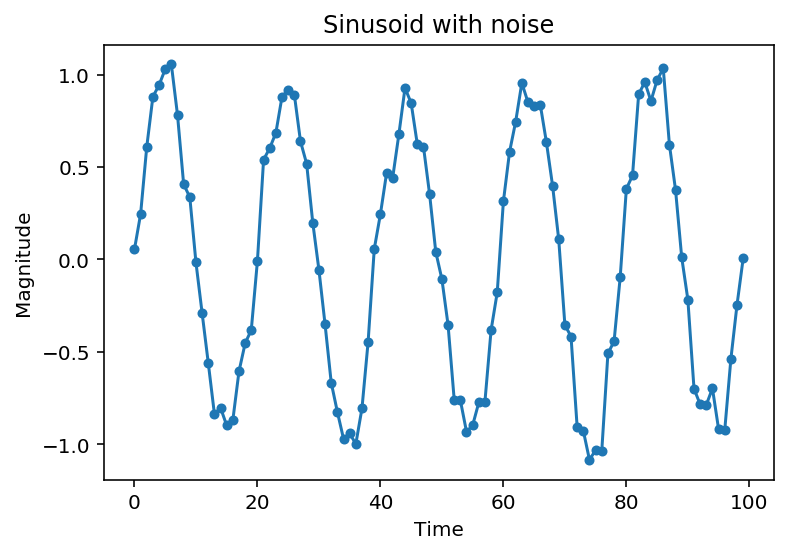

In [461]:
# Plotting sample data
plt.plot(generate_synthetic_data(100, 1), marker='o', markersize=4)
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Sinusoid with noise');

In [ ]:
mtrnn = MTRNN()
optimizer = Adam(params=mtrnn.parameters(), lr=1e-4)

for epoch in range(1000):
    train_data = torch.from_numpy(generate_synthetic_data(sequence_length=100, batch_size=64)).unsqueeze(dim=-1)
    output, _ = mtrnn(train_data)
    loss = mse_loss(output, train_data)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, loss: {loss.detach().numpy():.2f}')

Epoch 0, loss: 0.79
Epoch 10, loss: 0.78
Epoch 20, loss: 0.75
Epoch 30, loss: 0.74
Epoch 40, loss: 0.74
Epoch 50, loss: 0.70
Epoch 60, loss: 0.71
Epoch 70, loss: 0.70
Epoch 80, loss: 0.68
Epoch 90, loss: 0.67
Epoch 100, loss: 0.66
Epoch 110, loss: 0.64
Epoch 120, loss: 0.63
Epoch 130, loss: 0.62
Epoch 140, loss: 0.62


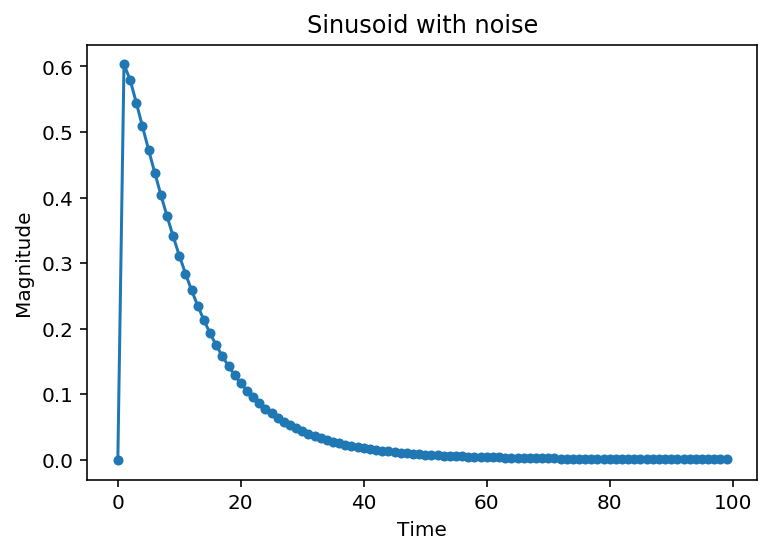

In [439]:
# Plotting sample data
plt.plot(mtrnn.generate_synthetic_data().detach().squeeze().numpy(), marker='o', markersize=4)
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Sinusoid with noise');